In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler  # shown but not used for trees
from xgboost import XGBClassifier

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # keep output cleaner
RANDOM_STATE = 42

*Tree types found in the Roosevelt National Forest in Colorado*

In [ ]:
# Load the CSV file into a pandas DataFrame.
data = pd.read_csv("/content/covtype.csv")

# Show the first 5 rows of the dataset to understand its structure.
print(data.head())

# Show basic info: column names, non-null counts, and datatypes.
print(data.info())

# Show summary statistics of numerical columns (mean, min, max, quartiles).
print(data.describe())

   Elevation  Aspect  Slope  ...  Soil_Type39  Soil_Type40  Cover_Type
0       2596      51      3  ...            0            0         5.0
1       2590      56      2  ...            0            0         5.0
2       2804     139      9  ...            0            0         2.0
3       2785     155     18  ...            0            0         2.0
4       2595      45      2  ...            0            0         5.0

[5 rows x 55 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Elevation                           8143 non-null   int64  
 1   Aspect                              8143 non-null   int64  
 2   Slope                               8143 non-null   int64  
 3   Horizontal_Distance_To_Hydrology    8143 non-null   int64  
 4   Vertical_Distance_To_Hydrology      8143 non-null

In [ ]:
# Data Cleaning

#Check for missing values
print("Missing Values:",data.isnull().sum())

#Check for duplicate rows
print("Duplicate rows:",data.duplicated().sum())

#Check data types of each column
print("Data Types:",data.dtypes)

#Shape of dataset (rows, columns)
print("Dataset Shape:",data.shape)

#Target variable distribution (class balance check)
print("Class Distribution:",data['Cover_Type'].value_counts())

#Basic statistical summary to detect extreme outliers
print("Summary Statistics:",data.describe())

# After cleaning, confirm shape
print("Dataset shape after cleaning:", data.shape)


Missing Values: Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11             

In [ ]:
# Target column name commonly 'Cover_Type' (values 1..7)
target_col = "Cover_Type"
if target_col not in data.columns:
    raise ValueError(f"Expected target column '{target_col}' not found in dataset.")

# Drop rows with missing target values
data.dropna(subset=[target_col], inplace=True)

X = data.drop(columns=[target_col])   # feature matrix (all columns except the target)
y = data[target_col].astype(int)      # target vector (ensure integer labels)
print("Feature shape:", X.shape, "Target shape:", y.shape)

Feature shape: (8142, 54) Target shape: (8142,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (6513, 54) Test shape: (1629, 54)


In [ ]:

# 6. (Optional) Scaling - NOT required for tree models

# For demonstration: if you later use logistic regression / SVM, you'd scale:
# scaler = StandardScaler()
# numeric_cols = [c for c in X.columns if X[c].nunique() > 2]  # rough heuristic
# X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
# X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])


Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,            # number of trees
    max_depth=None,              # allow full grow (can tune)
    n_jobs=-1,                   # use all CPU cores
    random_state=RANDOM_STATE,
    class_weight=None            # set 'balanced' if you want to counter class imbalance
)

rf.fit(X_train, y_train)        # train the Random Forest
y_pred_rf = rf.predict(X_test)  # predictions on test set
print("Random Forest accuracy (test):", accuracy_score(y_test, y_pred_rf))
print("Classification report of Random Forest:", classification_report(y_test, y_pred_rf))


Random Forest accuracy (test): 0.858195211786372
Classification report of Random Forest:               precision    recall  f1-score   support

           1       0.78      0.68      0.73       168
           2       0.78      0.81      0.79       242
           3       0.81      0.78      0.79       237
           4       0.93      0.95      0.94       324
           5       0.91      0.94      0.92       274
           6       0.82      0.85      0.83       252
           7       0.96      0.94      0.95       132

    accuracy                           0.86      1629
   macro avg       0.86      0.85      0.85      1629
weighted avg       0.86      0.86      0.86      1629



XG Boost

In [ ]:
num_classes = y.nunique()

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Subtract 1 from y_train and y_test to make them 0-indexed
xgb.fit(X_train, y_train - 1)        # train XGBoost
y_pred_xgb = xgb.predict(X_test) + 1 # predictions on test set, add 1 back for evaluation

print("XGBoost accuracy (test):", accuracy_score(y_test, y_pred_xgb))
print("Classification report of XGBoost:", classification_report(y_test, y_pred_xgb))

XGBoost accuracy (test): 0.8606507059545734
Classification report of XGBoost:               precision    recall  f1-score   support

           1       0.75      0.70      0.72       168
           2       0.80      0.75      0.77       242
           3       0.83      0.79      0.81       237
           4       0.93      0.95      0.94       324
           5       0.92      0.95      0.93       274
           6       0.83      0.88      0.85       252
           7       0.91      0.95      0.93       132

    accuracy                           0.86      1629
   macro avg       0.85      0.85      0.85      1629
weighted avg       0.86      0.86      0.86      1629



Confusion Matrix

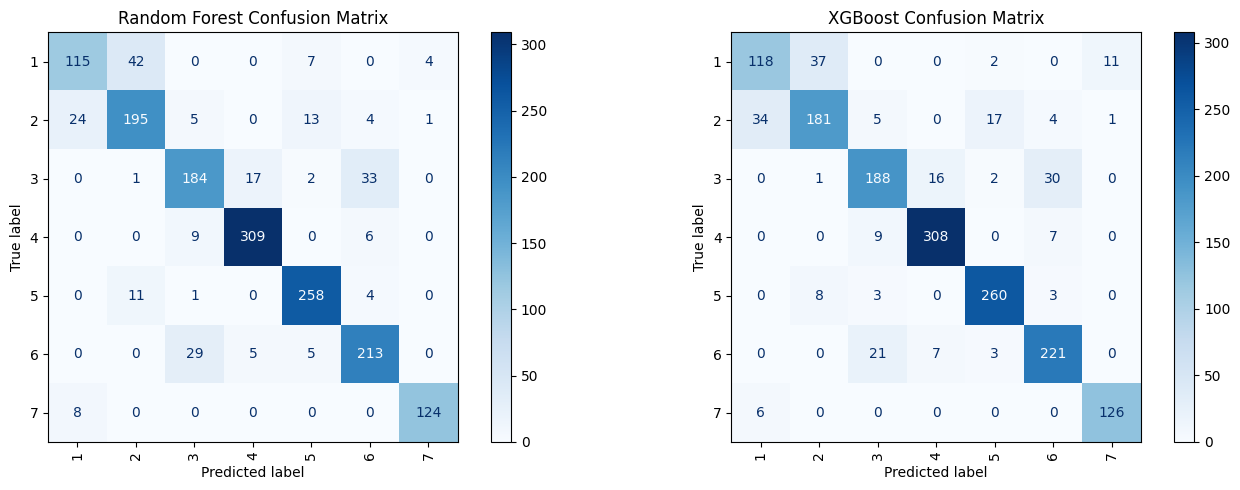

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=sorted(y.unique()))
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=sorted(y.unique()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
disp1 = ConfusionMatrixDisplay(cm_rf, display_labels=sorted(y.unique()))
disp2 = ConfusionMatrixDisplay(cm_xgb, display_labels=sorted(y.unique()))
disp1.plot(ax=axes[0], xticks_rotation='vertical', cmap=plt.cm.Blues)
axes[0].set_title("Random Forest Confusion Matrix")
disp2.plot(ax=axes[1], xticks_rotation='vertical', cmap=plt.cm.Blues)
axes[1].set_title("XGBoost Confusion Matrix")
plt.tight_layout()
plt.show()

Top 20 Random Forest features:
 Elevation                             0.195035
Horizontal_Distance_To_Roadways       0.101112
Horizontal_Distance_To_Fire_Points    0.076221
Horizontal_Distance_To_Hydrology      0.071866
Vertical_Distance_To_Hydrology        0.059635
Hillshade_9am                         0.058333
Aspect                                0.052979
Hillshade_3pm                         0.051586
Hillshade_Noon                        0.048197
Wilderness_Area4                      0.042683
Slope                                 0.040124
Wilderness_Area1                      0.032905
Soil_Type3                            0.023792
Soil_Type10                           0.019397
Wilderness_Area3                      0.018656
Soil_Type38                           0.015687
Soil_Type39                           0.013330
Soil_Type30                           0.010084
Soil_Type29                           0.006549
Soil_Type2                            0.005776
dtype: float64

Top 20 XGBoo

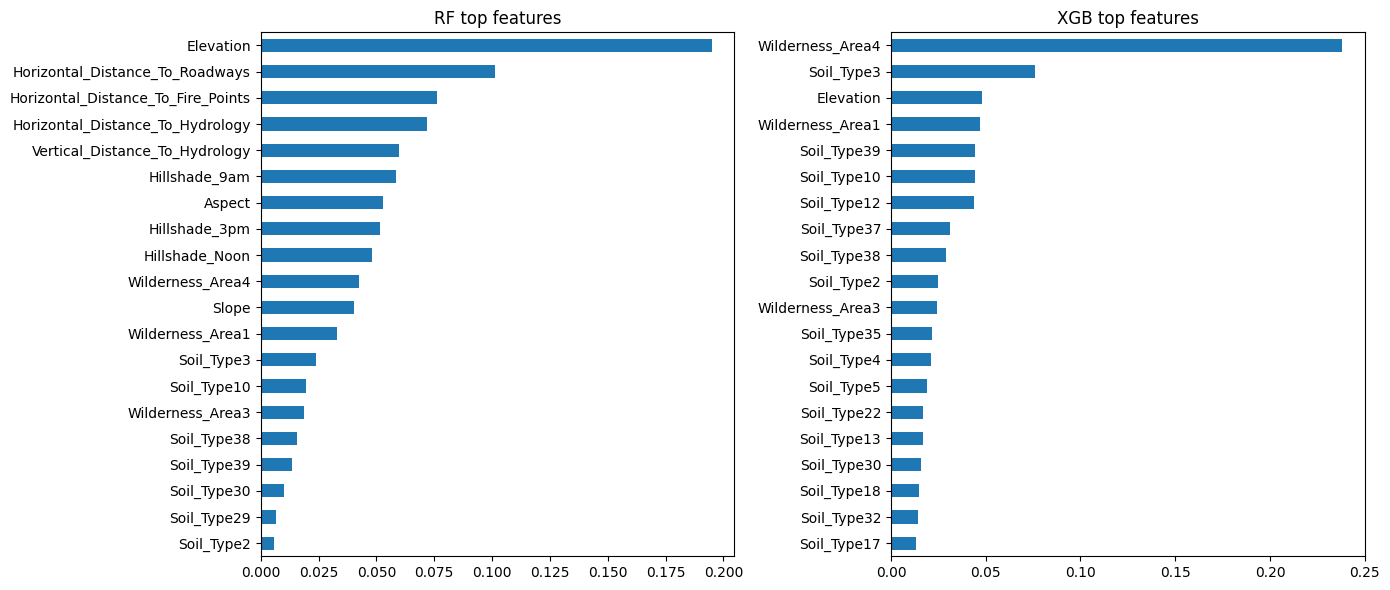

In [ ]:
# Feature importances
# Random Forest importances
rf_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
print("Top 20 Random Forest features:\n", rf_imp)

# XGBoost importances
xgb_imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
print("\nTop 20 XGBoost features:\n", xgb_imp)

# Plot top importances side-by-side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
rf_imp.plot(kind="barh", ax=ax[0]); ax[0].invert_yaxis(); ax[0].set_title("RF top features")
xgb_imp.plot(kind="barh", ax=ax[1]); ax[1].invert_yaxis(); ax[1].set_title("XGB top features")
plt.tight_layout(); plt.show()

In [ ]:
#Hyperparameter Tuning
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 12],
    "class_weight": [None, "balanced"]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                    param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best RF params:", grid.best_params_)
print("Best RF CV score:", grid.best_score_)
best_rf = grid.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 200}
Best RF CV score: 0.8380162751420236


In [ ]:
#Save model to the disk
joblib.dump(rf, "rf_forest_cover.joblib")
joblib.dump(xgb, "xgb_forest_cover.joblib")

['xgb_forest_cover.joblib']